## Tree-Based Methods

In [1]:
# Load necessary packages
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_digits 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, precision_recall_fscore_support as score

%matplotlib inline

### Train and view a tree

Let's try a decision tree on Iris data.

In [2]:
# Loading the iris dataset from the sklearn package
iris = load_iris()

# Display the column names
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


In [3]:
# A nicer display with the number codes
key = ', '.join(['{}={}'.format(i,name) for i,name in enumerate(iris.target_names)])
key

'0=setosa, 1=versicolor, 2=virginica'

In [4]:
# First let's create a train and test split
# (we set the random state so we get the same results if we rerun this)
X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=5) 

In [5]:
# Let's fit a decision tree model
tree_iris = DecisionTreeClassifier(max_depth=2, criterion='entropy')
_ = tree_iris.fit(X_train, Y_train)

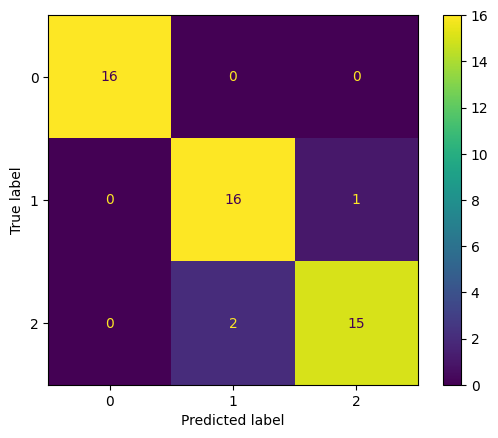

In [6]:
### Evaluate the model
# First generate predictions from the test features
Y_pred = tree_iris.predict(X_test)

# Generate a confusion matrix
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
plt.show()

In [7]:
print('Classification report ({}):\n'.format(key))
print(classification_report(Y_test, Y_pred))

Classification report (0=setosa, 1=versicolor, 2=virginica):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.89      0.94      0.91        17
           2       0.94      0.88      0.91        17

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



In [9]:
# Compute aggregate accuracy, precision, recall and F-score
precision, recall, fscore, support = score(Y_test, Y_pred, average='macro')
accuracy = accuracy_score(Y_test, Y_pred)
print('Accuracy: {} / Precision: {} / Recall: {} / F1-score: {}'.format(round(accuracy, 3),
                                                                        round(precision, 3),
                                                                        round(recall, 3),
                                                                        round(fscore,3)))

Accuracy: 0.94 / Precision: 0.942 / Recall: 0.941 / F1-score: 0.941


Check that these results match the ones reported in the classification report. Next we will display the tree first graphically, then as a Python code of if-else statements

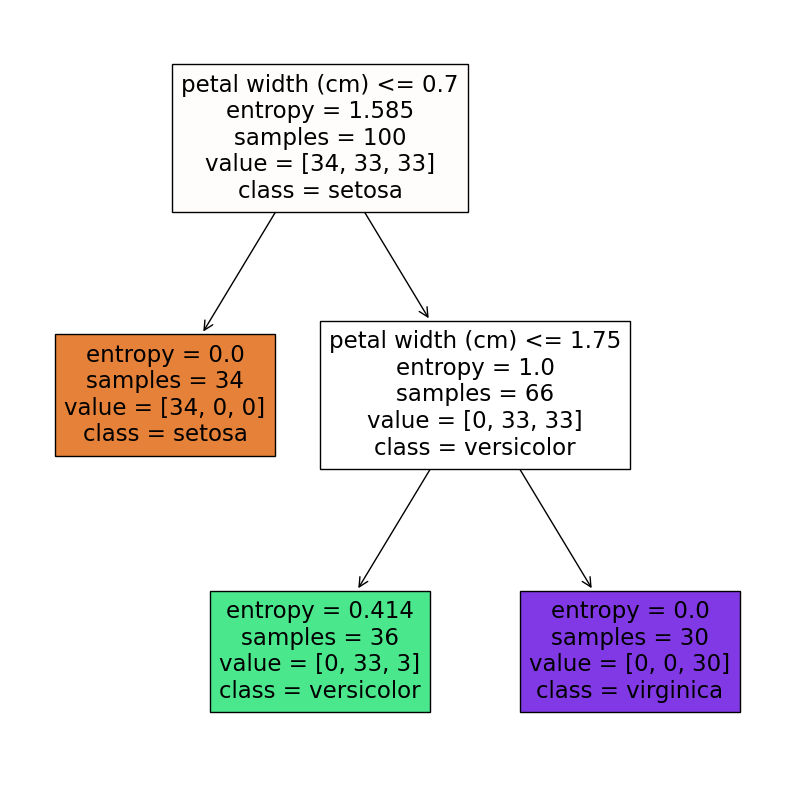

In [10]:
fig = plt.figure(figsize = (10, 10))
_ = plot_tree(tree_iris, 
              feature_names = iris.feature_names,  
              class_names = iris.target_names,
              filled = True)

The number of samples at the root node is 100 because we have 100 examples in the training set. 

In [11]:
# To export the resulting tree as an image file
fig.savefig("DT_iris.png")

Now let's represent the decision tree as a sequence of if-else statements

In [12]:
#From http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html
def get_code(tree, feature_names, target_names, spacer_base="    "):
    """Produce psuedo-code for decision tree.

    Args
    ----
    tree -- scikit-leant DescisionTree.
    feature_names -- list of feature names.
    target_names -- list of target (class) names.
    spacer_base -- used for spacing code (default: "    ").

    Notes
    -----
    based on http://stackoverflow.com/a/30104792.
    """
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth):
        spacer = spacer_base * depth
        if (threshold[node] != -2):
            print(spacer + "if ( " + features[node] + " <= " + \
                  str(threshold[node]) + " ) {")
            if left[node] != -1:
                    recurse(left, right, threshold, features,
                            left[node], depth+1)
            print(spacer + "}\n" + spacer +"else {")
            if right[node] != -1:
                    recurse(left, right, threshold, features,
                            right[node], depth+1)
            print(spacer + "}")
        else:
            target = value[node]
            for i, v in zip(np.nonzero(target)[1],
                            target[np.nonzero(target)]):
                target_name = target_names[i]
                target_count = int(v)
                print(spacer + "return " + str(target_name) + \
                      " ( " + str(target_count) + " examples )")

    recurse(left, right, threshold, features, 0, 0)

In [13]:
print('Decision tree:\n')
get_code(tree_iris, iris.feature_names, iris.target_names)

Decision tree:

if ( petal width (cm) <= 0.7000000029802322 ) {
    return setosa ( 1 examples )
}
else {
    if ( petal width (cm) <= 1.75 ) {
        return versicolor ( 0 examples )
        return virginica ( 0 examples )
    }
    else {
        return virginica ( 1 examples )
    }
}


## EXERCISE: Model selection on test data

### TODO Compare classifiers

1) Choose the decision tree max_depth in [2..6], criterion in ['entropy', 'gini'] and splitter in ['best', 'random']. What are the best parameters? Print out all grid scores to sanity check the selection. Is there a unique best set of parameters?

2) Create `l_yn` and `t_yn` arrays showing respectively, for logistic regression and decision tree, whether each test instance is predicted correctly (`1`) or incorrectly (`0`).

3) Which classifier is better (use f-score measure)?

In [14]:
# TODO: replace the content of this cell with your solution
# Q1

# Parameters to explore
params = { 
    'max_depth': [2, 3, 4, 5, 6],
    'criterion': ['entropy', 'gini'],
    'splitter': ['best', 'random']
}

# initialise the model
tree_iris = DecisionTreeClassifier() 

# Perform the grid search
np.random.seed(0) # we set the seed here to be able to get the same results each time we run the grid search
gs_tree = GridSearchCV(tree_iris, params, cv = 5, scoring = 'f1_macro', n_jobs = -1)  # We will evaluate the models based on F1-score
gs_tree_fit = gs_tree.fit(X_train, Y_train)

# Store the results as a dataframe
gs_tree_resuls = pd.DataFrame(gs_tree_fit.cv_results_).sort_values('mean_test_score', ascending=False)
gs_tree_resuls.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.000324,0.000058,0.000523,0.000029,entropy,5,random,"{'criterion': 'entropy', 'max_depth': 5, 'spli...",1.0,0.896825,1.0,0.896825,1.0,0.958730,0.050545,1
18,0.000254,0.000051,0.000476,0.000048,gini,6,best,"{'criterion': 'gini', 'max_depth': 6, 'splitte...",1.0,0.896825,1.0,0.896825,1.0,0.958730,0.050545,1
5,0.000582,0.000670,0.000577,0.000204,entropy,4,random,"{'criterion': 'entropy', 'max_depth': 4, 'spli...",1.0,0.896825,1.0,0.896825,1.0,0.958730,0.050545,1
0,0.000649,0.000251,0.000873,0.000234,entropy,2,best,"{'criterion': 'entropy', 'max_depth': 2, 'spli...",1.0,0.896825,1.0,0.891667,1.0,0.957698,0.051834,4
16,0.000241,0.000035,0.000513,0.000060,gini,5,best,"{'criterion': 'gini', 'max_depth': 5, 'splitte...",1.0,0.896825,1.0,0.891667,1.0,0.957698,0.051834,4


In [15]:
### Compact display

# Max width of columns when dispalying datasets
pd.set_option('display.max_colwidth', 100)

gs_tree_resuls[['params', 'mean_test_score']]

,params,mean_test_score
7,"{'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}",0.958730
18,"{'criterion': 'gini', 'max_depth': 6, 'splitter': 'best'}",0.958730
5,"{'criterion': 'entropy', 'max_depth': 4, 'splitter': 'random'}",0.958730
0,"{'criterion': 'entropy', 'max_depth': 2, 'splitter': 'best'}",0.957698
16,"{'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}",0.957698
12,"{'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'}",0.957698
8,"{'criterion': 'entropy', 'max_depth': 6, 'splitter': 'best'}",0.957698
10,"{'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'}",0.957698
2,"{'criterion': 'entropy', 'max_depth': 3, 'splitter': 'best'}",0.957698
13,"{'criterion': 'gini', 'max_depth': 3, 'splitter': 'random'}",0.949963


In [16]:
# Print best parameters
print('\nBest parameters:', gs_tree.best_params_)


Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'splitter': 'random'}


In [17]:
# Evaluate on held-out test
print('\nClassification report ({}):\n'.format(key))
print(classification_report(Y_test, gs_tree.predict(X_test)))


Classification report (0=setosa, 1=versicolor, 2=virginica):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      0.94      0.94        17
           2       0.94      0.94      0.94        17

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



In [18]:
# TODO: replace the content of this cell with your solution
# Q2

# First let's fit a logistic regression model to the data
logreg = LogisticRegression()
_ = logreg.fit(X_train, Y_train)

In [19]:
# Calculate whether each test prediction is correct for both the decision tree and logistic regression models
l_yn = np.array([int(p==t) for p,t in zip(logreg.predict(X_test), Y_test)])
t_yn = np.array([int(p==t) for p,t in zip(gs_tree.predict(X_test), Y_test)])

# There's very little difference in this data set
print(l_yn)
print(t_yn)

[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [20]:
### Compute aggregate accuracy, precision, recall and F-score for each model
# Logistic regression
precision_l, recall_l, fscore_l, support_l = score(Y_test, logreg.predict(X_test), average='macro')
accuracy_l = accuracy_score(Y_test, logreg.predict(X_test))
print('Logistic regression: Accuracy: {} / Precision: {} / Recall: {} / F1-score: {}'.format(round(accuracy_l, 3),
                                                                                             round(precision_l, 3),
                                                                                             round(recall_l, 3),
                                                                                             round(fscore_l,3)))

# Decision tree 
precision_t, recall_t, fscore_t, support_t = score(Y_test, gs_tree.predict(X_test), average='macro')
accuracy_t = accuracy_score(Y_test, gs_tree.predict(X_test))
print('Decision tree: Accuracy: {} / Precision: {} / Recall: {} / F1-score: {}'.format(round(accuracy_t, 3),
                                                                                       round(precision_t, 3),
                                                                                       round(recall_t, 3),
                                                                                       round(fscore_t,3)))

Logistic regression: Accuracy: 0.98 / Precision: 0.981 / Recall: 0.98 / F1-score: 0.98
Decision tree: Accuracy: 0.96 / Precision: 0.961 / Recall: 0.961 / F1-score: 0.961


## *STOP PLEASE. THE FOLLOWING IS FOR THE NEXT EXERCISE. THANKS.*

# From data to decisions


## EXERCISE: Assessing Decision Tree fit

### Load and split data

scikit-learn provides a `train_test_split` function (in `sklearn.cross_validation`). However, there is no function to do a three-way split into training, valdiation and test data.

Let's create a three-way 50/25/25 train/validation/test split by using `train_test_split` two times.

In [22]:
# load digits data
digits = load_digits()
X, y = digits.data, digits.target
X_td, X_test, y_td, y_test = train_test_split(digits.data, digits.target, test_size=0.25,
                                              random_state=5) # so we get the same results
X_train, X_val, y_train, y_val = train_test_split(X_td, y_td, test_size=0.33,
                                                  random_state=5) # so we get the same results

### Plot error vs complexity for decision tree

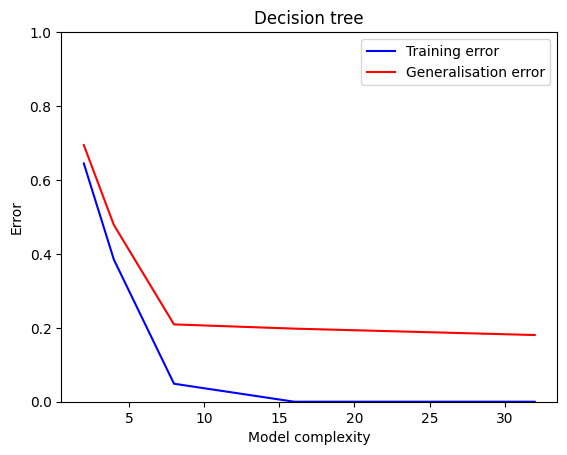

In [23]:
NUM_SAMPLES = 10

def subsample(X, y, sample_size):
    xy_tuples = list(zip(X, y))
    xy_sample = [random.choice(xy_tuples) for _ in range(sample_size)]
    X_sample, y_sample = zip(*xy_sample)
    return X_sample, y_sample

def error(clf, X, y):
    "Calculate error as 1-accuracy"
    return 1-clf.score(X,y)

def bootstrap_error(clf, X_train, y_train, X_test, y_test, sample_size, num_samples = NUM_SAMPLES):
    train_errors = []
    test_errors = []
    for _ in range(num_samples):
        X_sample, y_sample = subsample(X_train, y_train, sample_size)
        clf.fit(X_sample, y_sample)
        train_errors.append(error(clf,X_sample,y_sample))
        test_errors.append(error(clf,X_test,y_test))
    train_error = sum(train_errors)/len(train_errors)
    test_error = sum(test_errors)/len(test_errors)
    return train_error, test_error

complexities = []
train_errors = []
test_errors = []
for max_depth in [2, 4, 8, 16, 32, None]:
    clf = DecisionTreeClassifier(max_depth = max_depth)
    sample_size = len(y_train)
    train_error, test_error = bootstrap_error(clf, X_train, y_train, X_val, y_val, sample_size)
    complexities.append(max_depth)
    train_errors.append(train_error)
    test_errors.append(test_error)
plt.plot(complexities, train_errors, c = 'b', label = 'Training error')
plt.plot(complexities, test_errors, c = 'r', label = 'Generalisation error')
plt.ylim(0, 1)
plt.ylabel('Error')
plt.xlabel('Model complexity')
plt.title('Decision tree')
plt.legend()
plt.show()

### TODO Assessing decision tree fit

- Does training or generalisation error level out first? Why?
- What is the best value of max_depth based on this plot?
- Why doesn't generalisation error increase on the right

In [24]:
# 1 - Generalisation error levels out first.
#     This suggests that higher values of max_depth may lead to overfitting.

# 2 - max_depth=8. This gives the best generalisation error with lower 
#     model complexity and less risk of overfitting.

# 3 - The algorithm has other mechanisms to prevent overfitting.
#     And overfitting doesn't seem to hurt generalisation too much on this data.
#     Nevertheless, decision trees can overfit so use with caution.

## *STOP PLEASE. THE FOLLOWING IS FOR THE NEXT EXERCISE. THANKS.*

## EXERCISE: Ensembling classifiers

### Plot error vs complexity for random forest

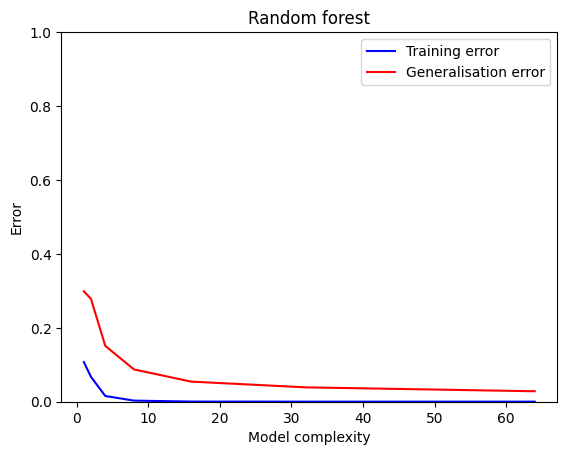

In [25]:
complexities = []
train_errors = []
test_errors = []
for n_estimators in [1, 2, 4, 8, 16, 32, 64]:
    clf = RandomForestClassifier(n_estimators = n_estimators, max_depth = 8)
    sample_size = len(y_train)
    train_error, test_error = bootstrap_error(clf, X_train, y_train, X_val, y_val, sample_size)
    complexities.append(n_estimators)
    train_errors.append(train_error)
    test_errors.append(test_error)
plt.plot(complexities, train_errors, c = 'b', label = 'Training error')
plt.plot(complexities, test_errors, c = 'r', label = 'Generalisation error')
plt.ylim(0, 1)
plt.ylabel('Error')
plt.xlabel('Model complexity')
plt.title('Random forest')
plt.legend()
plt.show()

### Plot error vs number of training samples

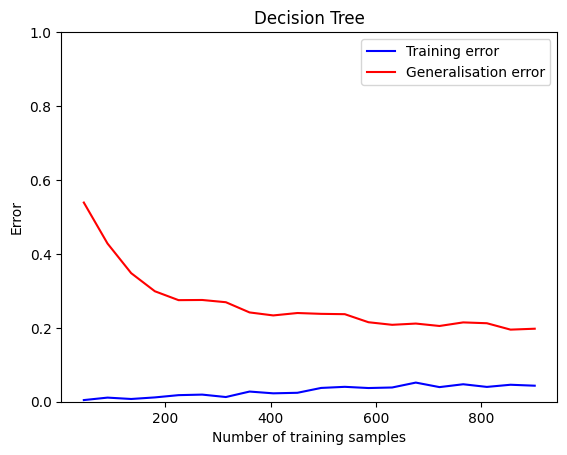

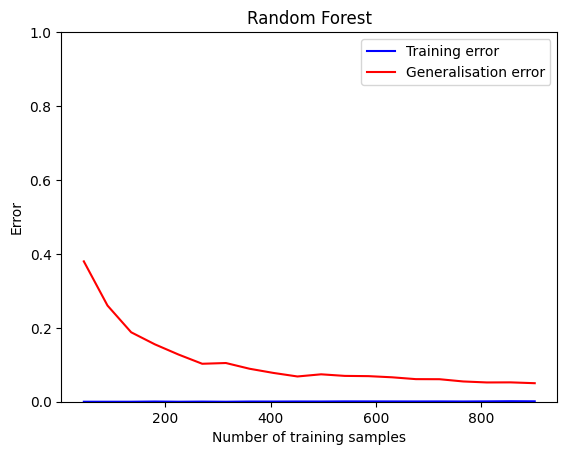

In [26]:
NUM_TRAIN_SETS = 20 # Number of training sub-datasets to create for performance evaluation 

def plot_error_curves(clf, X_train, y_train, X_test, y_test, num_train_sets=NUM_TRAIN_SETS, title=None):
    data_sizes = []
    train_errors = []
    test_errors = []
    for i in range(num_train_sets):
        sample_size = int(len(y_train) * (i+1)/num_train_sets)
        train_error, test_error = bootstrap_error(clf, X_train, y_train, X_test, y_test, sample_size)
        data_sizes.append(sample_size)
        train_errors.append(train_error)
        test_errors.append(test_error)
    plt.plot(data_sizes, train_errors, c='b', label='Training error')
    plt.plot(data_sizes, test_errors, c='r', label='Generalisation error')
    plt.ylim(0,1)
    plt.ylabel('Error')
    plt.xlabel('Number of training samples')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

# Note that we're passing dev data for estimating generalisation error here, not test data
dt = DecisionTreeClassifier(max_depth=8)
plot_error_curves(dt, X_train, y_train, X_val, y_val, title='Decision Tree')
rf = RandomForestClassifier(max_depth=8, n_estimators=16)
plot_error_curves(rf, X_train, y_train, X_val, y_val, title='Random Forest')

### TODO Comparing fit and data needed

- Which classifier would you use?
- Would it be useful to collect more training data?
- The decision tree has a larger spread between training and generalisation error. Why is this?
- Note we haven't yet used test data. When is it OK to use the test data from our train/validation/test split?

In [27]:
# 1 - Random forest is clearly better (error rates under 10% vs 20% for decision tree)

# 2 - Yes, almost always. However, it looks like both classifiers are close to their asymptotes.
#     So the benefit might not be worth the cost.
#     The decision tree would benefit more from additional data.

# 3 - The decision tree suffers more from overfitting.
#     The random forest on this particular data has 0 training error.
#     This is a bit of a surprise as random forests tend to increas bias.
#     With high bias, we would expect underfitting which tends to be 
#     characterised by both high training and high generalisation error.
#     However, random forests generally also reduce variance enough
#     to cancel out any increase in bias.
#     Here we end up with a nice generalisation error plot that seems
#     to be close to its asymptote and not too different from the
#     training error.

# 4 - As little as possible. Ideally only once for our final 
#     generalisation error/accuracy calculation. 